# Data Cleaning and Preprocessing

Für die Ausführung des Notebooks wird die Installation von Python und der Bibliotheken pandas, numpy, matplotlib und scikit-learn benötigt.
Zudem wird MLFlow verwendet, um die Modelle zu tracken und zu loggen. Der MLFlow Server muss installiert und gestartet sein.
TensorFlow wird für die Erstellung von neuronalen Netzen verwendet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature

# Tracking URL für den MLFlow Server setzen
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Rohdaten importieren
excel_file_path = '2023_eim.xlsx'
# alle Tabellenblätter in ein Dictionary einlesen
all_sheets_dict = pd.read_excel(excel_file_path, sheet_name=None)

# leere Liste erstellen, um die einzelnen DataFrames zu speichern
all_sheets_list = []

# Schleife über alle DataFrames in all_sheets_dict und diese in die Liste all_sheets_list einfügen
for sheet_name, sheet_df in all_sheets_dict.items():
    # Spalte 'Jahr' aus dem Sheet-Namen erstellen
    sheet_df['Jahr'] = sheet_name
    all_sheets_list.append(sheet_df)

# Zusammenführen der DataFrames in all_sheets_list zu einem DataFrame
combined_df = pd.concat(all_sheets_list, ignore_index=True)

# Speichern des DataFrames in eine Excel-Datei
combined_df.to_excel('2023_eim_combined.xlsx', index=False)

# Erstellen eines neuen DataFrames mit der Anzahl der einzigartigen Kunden und der Summe der fakturierbaren Tage, gruppiert nach 'Mitarbeiter' und 'Jahr'
grouped_df = combined_df.groupby(['Mitarbeiter', 'Jahr']).agg(
    num_customers=pd.NamedAgg(column='Anforderer', aggfunc='nunique'),
    sum_tage=pd.NamedAgg(column='Tage', aggfunc='sum')
).reset_index()

# Speichern des gruppierten DataFrames in eine Excel-Datei
grouped_df.to_excel('2023_eim_grouped.xlsx', index=False)

Die gruppierten Daten dienen als Basis für die weitere Aufbereitung der Daten, zu einer Excel Datei mit diversen Input Features.
Die Daten im zuvor erstellten DataFrame werden manuell angereichert. 
Hierzu zählen vor allen Dingen persönliche Daten, aber auch Informationen aus dem Vertriebsbereich.
- ist der Mitarbeiter in der Bestandskundenbetreuung tätig?
- Welches Skill-Level hat der Mitarbeiter in seinem Tätigkeitsgebiet?
- Alter des Mitarbeiters
- Berufserfahrung des Mitarbeiters
- Wie viele Fehltage sind im Jahr zu verzeichnen?
- Arbeitet der Mitarbeiter in Vollzeit oder Teilzeit?
- Wie viele Beratungstage sind für das kommende Jahr bereits fest eingeplant, durch vorhandene Aufträge? Wie schätzt der Teamleiter die mögliche Zielerreichung persönlich für den Mitarbeiter (konservativ aufgrund des Auftragsbestands) ein?


In [2]:
# importiere die Input Features aus einer Excel-Datei   
input_file_path = 'input_features.xlsx'

input_df = pd.read_excel(input_file_path)
# Anreicherung der Daten um Informationen zu den Arbeitstagen pro Jahr
arbeitstage = {2017: 247, 2018: 249, 2019: 249, 2020: 253, 2021: 253, 2022: 250, 2023: 248}
# Wirtschaftswachstum in Deutschland in Prozent
bip_deutschland = {2017: 2.7, 2018: 1, 2019: 1.1, 2020: -3.8, 2021: 3.2, 2022: 1.8, 2023: -0.3}
# FIS Umsatz pro Mitarbeiter in Euro
fis_turnover_per_employee = {2017: 98658, 2018: 102865, 2019: 104651, 2020: 107317, 2021: 109112, 2022: 111318, 2023: 114443}

# Spalte 'Arbeitstage' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['Arbeitstage'] = input_df['Jahr'].map(arbeitstage)
# Spalte 'Wirtschaftswachstum' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['Wirtschaftswachstum'] = input_df['Jahr'].map(bip_deutschland)
# Spalte 'FIS Umsatz pro Mitarbeiter' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['FIS Umsatz pro Mitarbeiter'] = input_df['Jahr'].map(fis_turnover_per_employee)
# Spalte 'Workdays' zum DataFrame hinzufügen, basierend auf der Spalte 'Vollzeit' multipliziert mit 'Arbeitstage'
input_df['Workdays'] = input_df['Vollzeit'] * input_df['Arbeitstage']

Kalkuliere, welche Kunden aus einer Kategorie die Berater in jeweiligen Jahr betreut haben.
Es soll nach Höhe des Aufwands geclustert werden.
Hat ein Berater einen Kunden mit mehr als 80 Tagen, so soll dieser in die Kunden Kategorie A fallen.
Hat ein Berater einen Kunden mit mehr als 40 Tagen, so soll dieser in die Kunden Kategorie B fallen.
Hat ein Berater einen Kunden mit weniger als 40 Tagen, so soll dieser in die Kunden Kategorie C fallen.
Hat ein Berater nur Kunden mit weniger als 10 Tagen soll in die Kunden Kategorie D fallen.

Es soll damit später geprüft werden, ob eine Korrelation zu den erzielten Beratungstagen besteht, wenn ein Berater einen Kunden betreut, bei dem viele Beratungstage anfallen.

In [3]:
# basierend auf dem combined_df DataFrame, erstelle ein neues DataFrame mit den Kunden Kategorien A, B, C, D pro Name

# filtere zunächst das combined_df DataFrame, wähle den höchsten Wert von 'Tage' für jeden 'Mitarbeiter' und 'Jahr'
customers_filtered_highest_df = combined_df.loc[combined_df.groupby(['Mitarbeiter', 'Jahr'])['Tage'].idxmax()]
# Spalte 'Kategorie' zum DataFrame hinzufügen
customers_filtered_highest_df['Kunden Kategorie'] = ''
# weise Kategorie D zu, wenn der Berater nur Kunden mit weniger als 10 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] <= 10, 'Kunden Kategorie'] = 0
# weise Kategorie C zu, wenn der Berater Kunden mit weniger als 40 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 10, 'Kunden Kategorie'] = 1
# weise Kategorie B zu, wenn der Berater Kunden mit weniger als 80 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 40, 'Kunden Kategorie'] = 2
# weise Kategorie A zu, wenn der Berater Kunden mit mehr als 80 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 80, 'Kunden Kategorie'] = 3
# speichere das DataFrame in eine Excel-Datei
customers_filtered_highest_df.to_excel('customers_filtered_highest.xlsx', index=False)


In [4]:
# 'Jahr' zu int konvertieren in beiden DataFrames
input_df['Jahr'] = input_df['Jahr'].astype(int)
customers_filtered_highest_df['Jahr'] = customers_filtered_highest_df['Jahr'].astype(int)

# basierend auf 'Name' und 'Jahr', 'Kategorie' von customers_filtered_highest_df zu input_df hinzufügen
input_df = input_df.merge(customers_filtered_highest_df[['Mitarbeiter', 'Jahr', 'Kunden Kategorie']], left_on=['Name', 'Jahr'], right_on=['Mitarbeiter', 'Jahr'], how='left')

# lösche die Spalte 'Mitarbeiter' aus dem DataFrame wegen Datenschutz
# der Name des Mitarbeiters ist nicht wichtig für das Modell
input_df.drop(columns=['Mitarbeiter', 'Name'], inplace=True)

# 'Kunden Kategorie' zu int konvertieren
input_df['Kunden Kategorie'] = input_df['Kunden Kategorie'].astype(int)


In [5]:
# der vorliegende Datenframe wird auf Berater gefiltert, bei denen die notwendigen Input Features vorhanden sind.
# es genügt in diesem Fall auf die Spalte 'Alter' zu prüfen
input_df = input_df[input_df['Alter'].notna()]

# der gefilterte DataFrame wird in eine Excel-Datei gespeichert
input_df.to_excel('input_features_filtered.xlsx', index=False)

Der Aufbau der notwendigen Input Features ist abgeschlossen.
Im Weiteren folgt die Datenanalyse und das erstellen der Modelle.

# Datenanalyse

## Beschreibung der Input Features
<table>
<tr>
        <th>Spalte</th>
        <th>Beschreibung</th>
        <th>Feature Typ</th>
    </tr>
    <tr>
        <td>Alter</td>
        <td>Alter des Mitarbeiters in Jahren</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Berufserfahrung</td>
        <td>Berufserfahrung des Mitarbeiters in Jahren</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Anzahl Kunden</td>
        <td>Betreute Kunden im vorliegenden Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Bestandskunden</td>
        <td>Ist der Mitarbeiter in der Bestandskundenbetreuung tätig (Supportbereich oder Neukundenprojekte)</td>
        <td>Categorical - Nominal</td>
    </tr>
    <tr>
        <td>Skill Level</td>
        <td>Welches Skill Level hat der Mitarbeiter in der Skill Matrix des Unternehmens</td>
        <td>Categorical - Ordinal</td>
    </tr>
    <tr>
        <td>Fehltage</td>
        <td>Anzahl der Fehltage im Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Vollzeit</td>
        <td>Arbeitet der Mitarbeiter Vollzeit (=1) oder in Teilzeit (=jeweiliger Anteil zu 1)</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Auftragsbestand</td>
        <td>Anzahl an Beratungstagen, die durch neue Aufträge im neuen Jahr verplant sind und die der Teamleiter dem Mitarbeiter als konservativ eingeschätztes Ziel zugewiesen hat.</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Arbeitstage</td>
        <td>Anzahl der Arbeitstage im Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Wirtschaftswachstum</td>
        <td>Wirtschaftswachstum in Deutschland</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>FIS Umsatz pro Mitarbeiter</td>
        <td>Höhe des Umsatzes pro Mitarbeiter in der Firmengruppe</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Workdays</td>
        <td>Anzahl der Arbeitstage pro Mitarbeiter unter Berücksichtigung von Vollzeit oder Teilzeit</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Kunden Kategorie</td>
        <td>Hat der Mitarbeiter A, B oder C-Kunden betreut?</td>
        <td>Categorical - Ordinal</td>
    </tr>
    <tr>
        <td>Fakturierbare Tage</td>
        <td>Anzahl der fakturierbaren Arbeitstage pro Mitarbeiter</td>
        <td>Target</td>
    </tr>
</table>

In [6]:
# Der DataFrame besteht aus numerischen und kategorischen Daten.
# Die einzelnen Features werden entsprechend zugeordnet, für die weitere Analyse und das Erstellen der Modelle.
numeric_features = ['Alter', 
                    'Anzahl Kunden', 
                    'Berufserfahrung', 
                    'FIS Umsatz pro Mitarbeiter', 
                    'Workdays', 
                    'Fehltage', 
                    'Wirtschaftswachstum',
                    'Arbeitstage',
                    'Auftragsbestand']
ordinal_features = ['Skill Level',
                    'Kunden Kategorie']
nominal_features = ['Bestandskunden']

Für die unterschiedlichen Datentypen werden unterschiedliche Methoden zur Analyse der Korrelation mit der Zielvariablen verwendet.

In [7]:
# Aufteilen der Daten in Input Features und Target Variable
y = input_df['Fakturierbare Tage']

# Berechnung der Korrelation der einzelnen unabhängigen Variablen in X mit der Zielvariablen y
# Nutzung des Pearson-Korrelationskoeffizienten für numerische Variablen
correlation_numeric = input_df[numeric_features].corrwith(y)

# Nutzung der Spearman-Korrelation für kategorische Variablen
correlation_ordinal = input_df[ordinal_features].corrwith(y, method='spearman')

# Korrelation der nominalen Variablen mit der Zielvariablen 
from scipy.stats import pointbiserialr
correlation_nominal = input_df[nominal_features].apply(lambda x: pointbiserialr(x, y)[0])
print(correlation_numeric)
print(correlation_ordinal)
print(correlation_nominal)

# Zusammenführen der Korrelationen in einem DataFrame
correlation = pd.concat([correlation_numeric, correlation_ordinal, correlation_nominal])

Alter                         0.504499
Anzahl Kunden                -0.244389
Berufserfahrung               0.482362
FIS Umsatz pro Mitarbeiter    0.060326
Workdays                      0.079132
Fehltage                     -0.222794
Wirtschaftswachstum          -0.140110
Arbeitstage                  -0.011545
Auftragsbestand               0.918485
dtype: float64
Skill Level         0.613723
Kunden Kategorie    0.643981
dtype: float64
Bestandskunden   -0.579493
dtype: float64


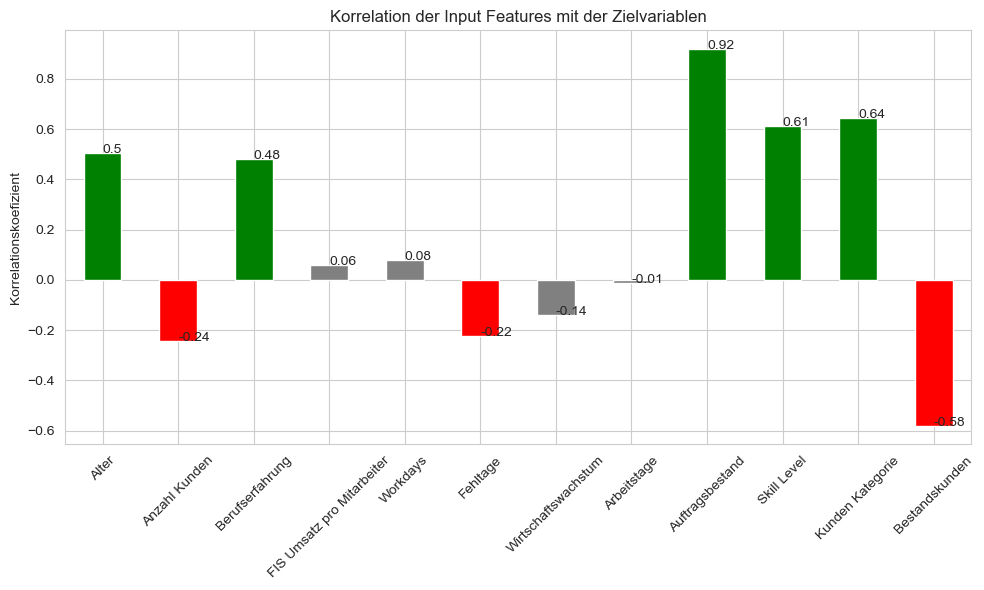

In [8]:
# zur Visualisierung der Korrelationen wird ein Balkendiagramm erstellt
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar', color=['green' if x > 0.2 else 'red' if x < -0.2 else 'grey' for x in correlation])
for index, value in enumerate(correlation):
    plt.text(index, value, str(round(value, 2)))
plt.title('Korrelation der Input Features mit der Zielvariablen')
plt.xlabel('')
plt.ylabel('Korrelationskoefizient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('correlation_plot.png', dpi=300)
plt.show()

## Fokus auf relevante Features

Gemäß der ermittelten Korrelationen erfolgt eine Fokussierung auf folgende Features:
- Alter
- Anzahl Kunden
- Berufserfahrung
- Fehltage
- Auftragsbestand
- Bestandskunden
- Skill Level
- Kunden Kategorie

In [9]:
numeric_features_used = ['Alter', 
                    'Anzahl Kunden', 
                    'Berufserfahrung',
                    'Fehltage', 
                    'Auftragsbestand']
ordinal_features_used = ['Skill Level',
                    'Kunden Kategorie']
nominal_features_used = ['Bestandskunden']

# Definition einer Variablen für sämtliche Input Features
X = input_df[numeric_features_used + ordinal_features_used + nominal_features_used]

### Berechnung der p-Werte

In [10]:
# Achtung Fehltage hat NaN Werte, daher werden diese entfernt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import pointbiserialr
p_values_numeric = {}
for feature in numeric_features_used:
    if feature != 'Fehltage':
        p_values_numeric[feature] = pearsonr(X[feature], y)[1]
    else:
        p_values_numeric[feature] = pearsonr(X[feature].dropna(), y[X[feature].dropna().index])[1]

# p-Werte für die ordinalen Features berechnen
p_values_ordinal = {}
for feature in ordinal_features_used:
    p_values_ordinal[feature] = spearmanr(X[feature], y)[1]
    
p_values_nominal = {}
for feature in nominal_features_used:
    p_values_nominal[feature] = pointbiserialr(X[feature], y)[1]
    
p_values = {**p_values_numeric, **p_values_ordinal, **p_values_nominal}

for p_value in p_values: 
    print(f'p-Wert für {p_value}: {p_values[p_value]}')
    if p_values[p_value] > 0.05:
        print('Die Korrelation ist nicht signifikant')
    else:
        print('Die Korrelation ist signifikant')
    print('.......................................................')

p-Wert für Alter: 1.9880609496311334e-09
Die Korrelation ist signifikant
.......................................................
p-Wert für Anzahl Kunden: 0.006020198305195097
Die Korrelation ist signifikant
.......................................................
p-Wert für Berufserfahrung: 1.2253094020536118e-08
Die Korrelation ist signifikant
.......................................................
p-Wert für Fehltage: 0.34509304325995527
Die Korrelation ist nicht signifikant
.......................................................
p-Wert für Auftragsbestand: 2.164888167908268e-51
Die Korrelation ist signifikant
.......................................................
p-Wert für Skill Level: 2.7436961295909635e-14
Die Korrelation ist signifikant
.......................................................
p-Wert für Kunden Kategorie: 5.441674605451085e-16
Die Korrelation ist signifikant
.......................................................
p-Wert für Bestandskunden: 1.4365736618721084e-12


Fehltage wird nicht als signifikant genug erachtet und daher nicht in das Model aufgenommen.


In [11]:
numeric_features_used = ['Alter', 
                    'Anzahl Kunden', 
                    'Berufserfahrung',
                    'Auftragsbestand']
ordinal_features_used = ['Skill Level',
                    'Kunden Kategorie']
nominal_features_used = ['Bestandskunden']
X = input_df[numeric_features_used + ordinal_features_used + nominal_features_used]

## Ermittlung von Multi-Kollinearität
Einige Features in X könnten miteinander korreliert sein. 

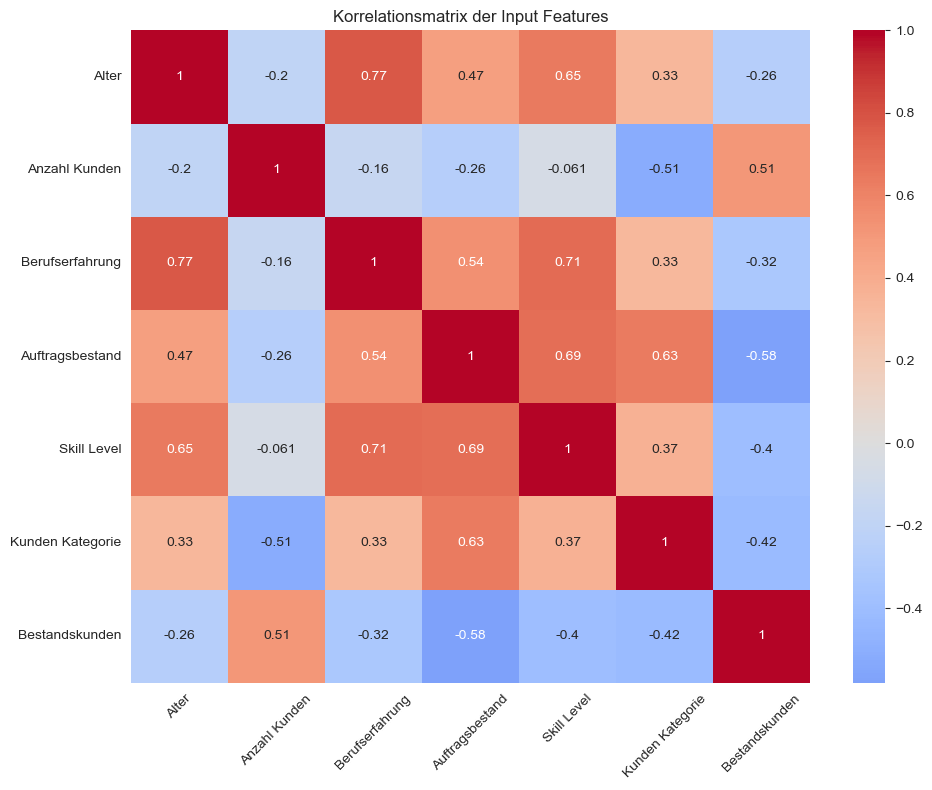

In [12]:
import seaborn as sns

# Erzeugen einer Korrelationsmatrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))

# Heatmap der Korrelationsmatrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Titel
plt.title('Korrelationsmatrix der Input Features')

# Plot Layout verfeinern und speichern
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)

# Plot anzeigen
plt.show()

Berufserfahrung und Alter korrelieren miteinander.
Wir verwenden im Folgenden das Alter als Input Feature und entfernen die Berufserfahrung.



In [13]:
numeric_features_used = ['Alter', 
                    'Anzahl Kunden', 
                    'Auftragsbestand']
ordinal_features_used = ['Skill Level',
                    'Kunden Kategorie']
nominal_features_used = ['Bestandskunden']
X = input_df[numeric_features_used + ordinal_features_used + nominal_features_used]

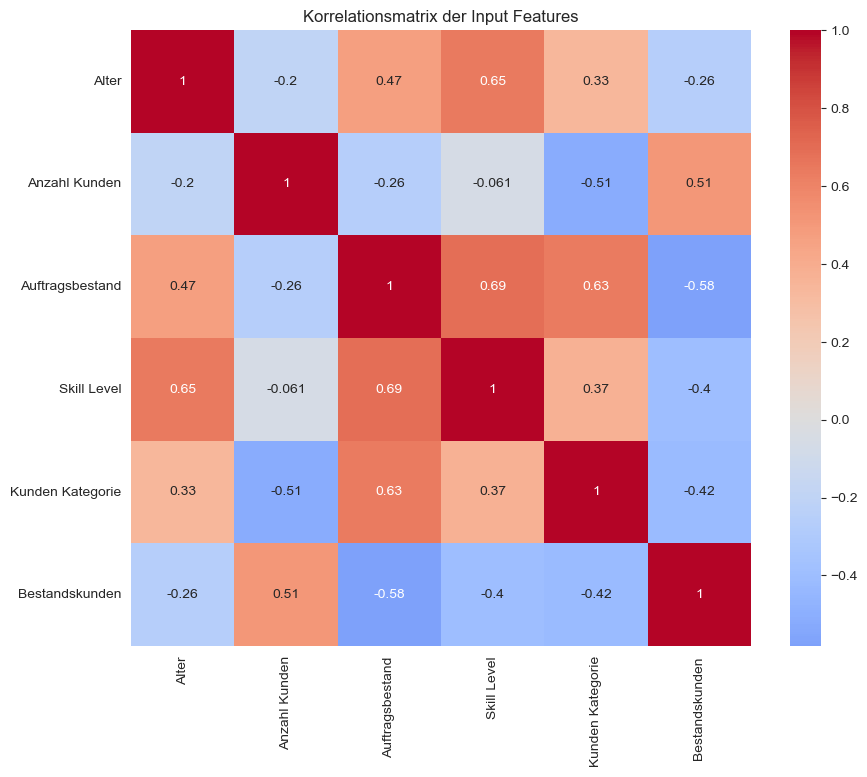

In [14]:
# Erzeugen einer Korrelationsmatrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))

# Heatmap der Korrelationsmatrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Titel
plt.title('Korrelationsmatrix der Input Features')

# Plot anzeigen
plt.show()

Im paarweisen Vergleich der Input Features untereinander, sind nun keine Korrelationskoeffizienten mehr zu erkennen, die größer als 0.7 sind.

In [15]:
# Plot for 'Alter'
plt.figure(figsize=(5, 5))
plt.scatter(X['Alter'], y)
plt.title('Alter')
plt.xlabel('Alter')
plt.ylabel('Fakturierbare Tage')
z = np.polyfit(X['Alter'], y, 2)
p = np.poly1d(z)
# sortieren der x-Werte notwendig, damit die Linie korrekt gezeichnet wird
alter_sorted = np.sort(X['Alter'])
plt.plot(alter_sorted, p(alter_sorted), linewidth=2, color='red')
plt.savefig('Alter_plot.png', dpi=300)
plt.close()

# Plot für 'Anzahl Kunden'
plt.figure(figsize=(5, 5))
plt.scatter(X['Anzahl Kunden'], y)
plt.title('Anzahl Kunden')
plt.xlabel('Anzahl Kunden')
plt.ylabel('Fakturierbare Tage')
z = np.polyfit(X['Anzahl Kunden'], y, 1)
p = np.poly1d(z)
plt.plot(X['Anzahl Kunden'], p(X['Anzahl Kunden']), linewidth=2, color='red')
plt.savefig('Anzahl_Kunden_plot.png', dpi=300)
plt.close()

# Plot for 'Auftragsbestand'
plt.figure(figsize=(5, 5))
plt.scatter(X['Auftragsbestand'], y)
plt.title('Experteneinschätzung: Auftragsbestand')
plt.xlabel('Auftragsbestand')
plt.ylabel('Fakturierbare Tage')
z = np.polyfit(X['Auftragsbestand'], y, 1)
p = np.poly1d(z)
auftragsbestand_sorted = np.sort(X['Auftragsbestand'])
plt.plot(auftragsbestand_sorted, p(auftragsbestand_sorted), linewidth=2, color='red')
plt.savefig('Auftragsbestand_plot.png', dpi=300)
plt.close()

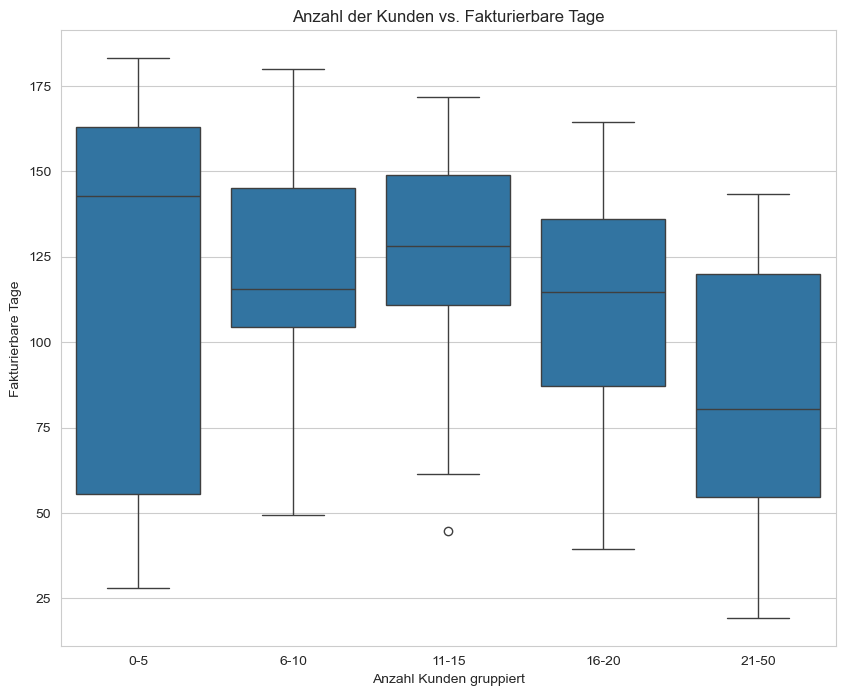

In [16]:
# box plots für X['Anzahl Kunden'] und 'Fakturierbare Tage'
input_df['Anzahl Kunden gruppiert'] = pd.cut(input_df['Anzahl Kunden'], bins=[0, 5, 10, 15, 20, 50], labels=['0-5', '6-10', '11-15', '16-20', '21-50'])
# boxplot für die unterschiedlichen Gruppen von 'Anzahl Kunden'
plt.figure(figsize=(10, 8))
sns.boxplot(x='Anzahl Kunden gruppiert', y='Fakturierbare Tage', data=input_df)
plt.title('Anzahl der Kunden vs. Fakturierbare Tage')
# export des boxplots als png
plt.savefig('Anzahl_Kunden_vs_Fakturierbare_Tage.png', dpi=300)
plt.show()






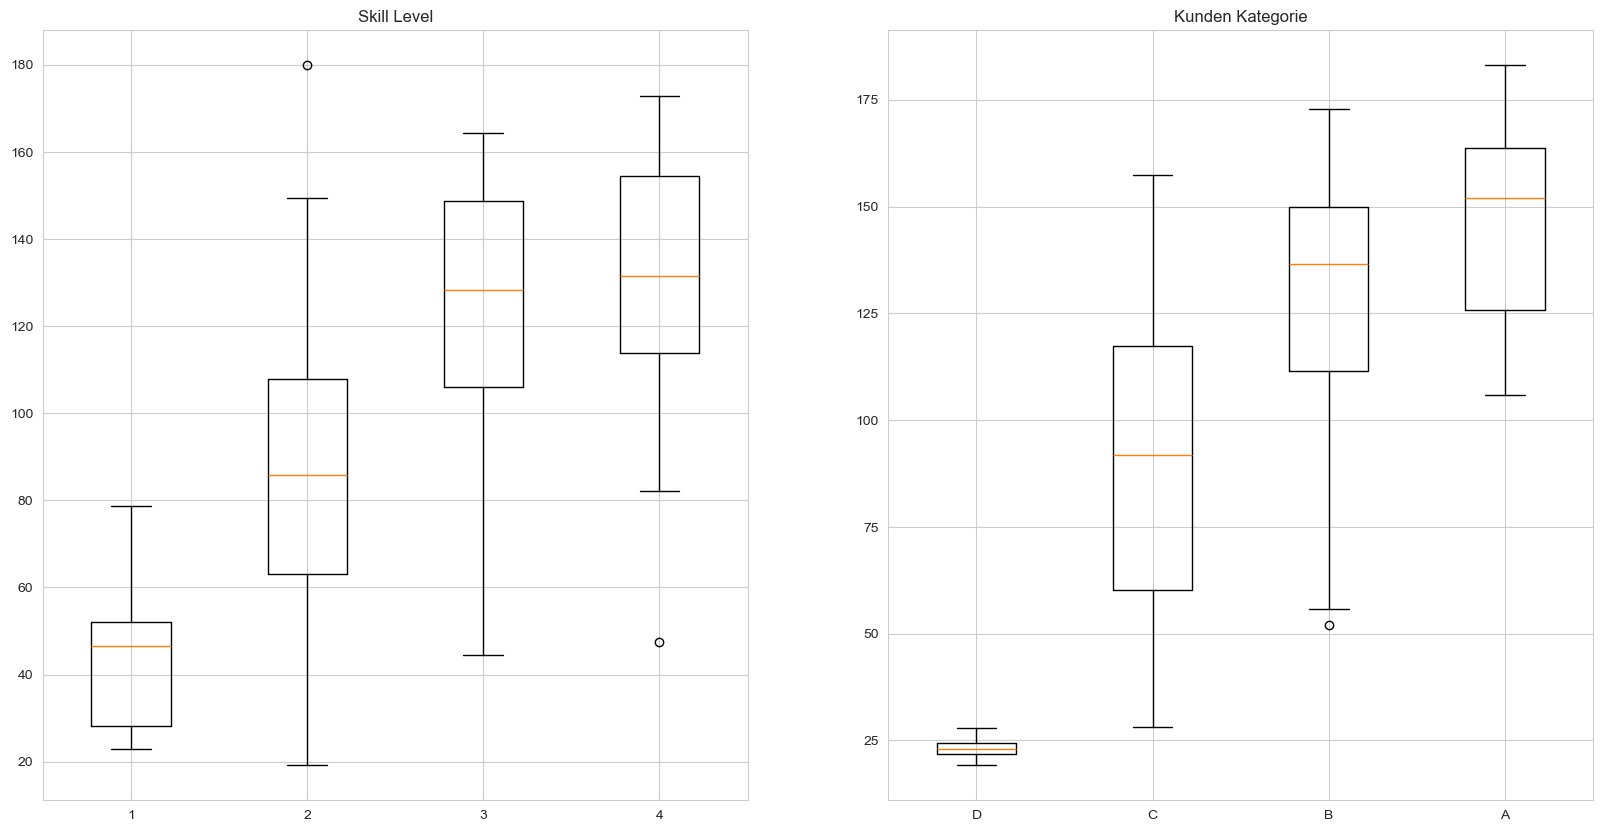

In [17]:
# Boxplots für die kategorischen ordinalen Input Features
# Boxplot für 'Skill Level', 'Kunden Kategorie'
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# boxplot 'Skill Level'
axs[0].boxplot([input_df[input_df['Skill Level'] == 1]['Fakturierbare Tage'], input_df[input_df['Skill Level'] == 2]['Fakturierbare Tage'], input_df[input_df['Skill Level'] == 3]['Fakturierbare Tage'], input_df[input_df['Skill Level'] == 4]['Fakturierbare Tage']])
axs[0].set_title('Skill Level')
axs[0].set_xticklabels(['1', '2', '3', '4'])
# boxplot 'Kunden Kategorie'
axs[1].boxplot([input_df[input_df['Kunden Kategorie'] == 0]['Fakturierbare Tage'], input_df[input_df['Kunden Kategorie'] == 1]['Fakturierbare Tage'], input_df[input_df['Kunden Kategorie'] == 2]['Fakturierbare Tage'], input_df[input_df['Kunden Kategorie'] == 3]['Fakturierbare Tage']])
axs[1].set_title('Kunden Kategorie')
axs[1].set_xticklabels(['D', 'C', 'B', 'A'])

plt.show()


In [18]:
# Boxplot 'Skill Level'
plt.figure(figsize=(10, 5))
skill_levels = [input_df[input_df['Skill Level'] == level]['Fakturierbare Tage'] for level in range(1, 5)]
plt.boxplot(skill_levels, labels=['1 - Junior', '2 - Consultant', '3 - Senior', '4 - Principal'])
plt.title('Skill Level')
plt.xlabel('Skill Level')
plt.ylabel('Fakturierbare Tage')
plt.savefig('Boxplot_Skill_Level.png', dpi=300)
plt.close()

# Boxplot 'Kunden Kategorie'
plt.figure(figsize=(10, 5))
kunden_kategorien = [input_df[input_df['Kunden Kategorie'] == kategorie]['Fakturierbare Tage'] for kategorie in range(4)]
plt.boxplot(kunden_kategorien, labels=['D - Kleinstprojekte', 'C', 'B', 'A - Großkunden'])
plt.title('Kunden Kategorie')
plt.xlabel('Kunden Kategorie')
plt.ylabel('Fakturierbare Tage')
plt.savefig('Boxplot_Kunden_Kategorie.png', dpi=300)
plt.close()

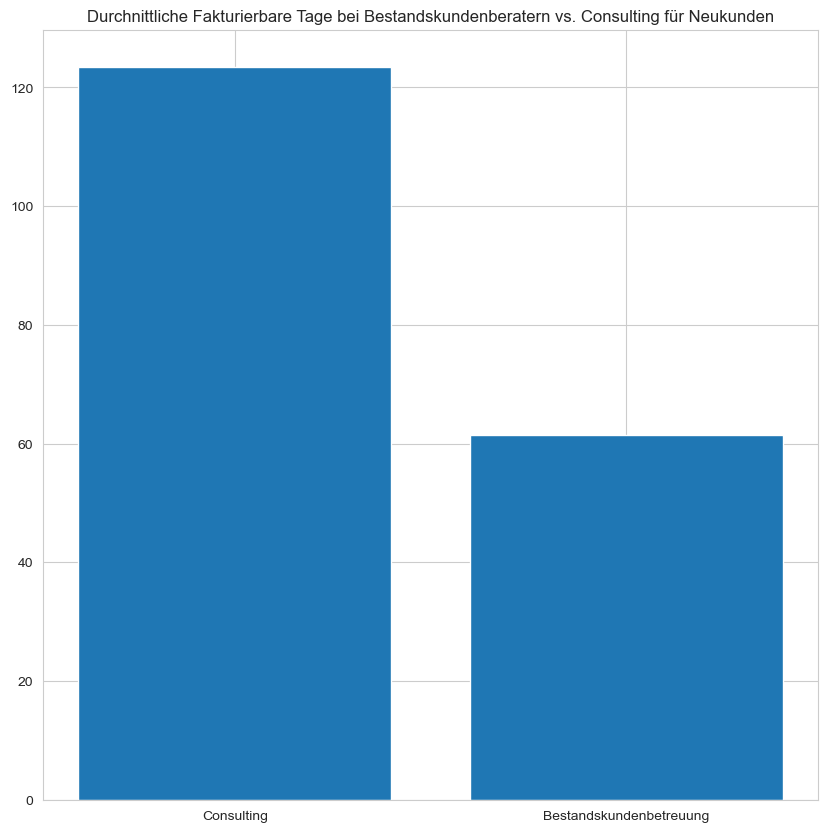

In [19]:
# Bar Chart für die nominalen Input Features
# Bar Chart für 'Bestandskunden'
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(['Consulting', 'Bestandskundenbetreuung'], [input_df[input_df['Bestandskunden'] == 0]['Fakturierbare Tage'].mean(), input_df[input_df['Bestandskunden'] == 1]['Fakturierbare Tage'].mean()])
ax.set_title('Durchnittliche Fakturierbare Tage bei Bestandskundenberatern vs. Consulting für Neukunden')

# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Bestandskunden', y='Fakturierbare Tage', data=input_df)
plt.title('Durchnittliche Fakturierbare Tage bei Bestandskundenberatern vs. Consulting für Neukunden')
# x-axis labels 'Consulting' und 'Bestandskundenbetreuung'
plt.xticks(ticks=[0, 1], labels=['Consulting', 'Bestandskundenbetreuung'])
plt.xlabel('')
plt.savefig('Boxplot_Bestandskunden.png', dpi=300)
plt.close()



In [20]:
# Kalkulation von RMSE und AME für 'Auftragsbestand' und der Zielvariable

# Mean Fakturierbare Tage
mean_fakturierbare_tage = y.mean()

# mean squared error
mse_auftragsbestand = np.mean((X['Auftragsbestand'] - y) ** 2)
# root mean squared error
rmse_auftragsbestand = np.sqrt(mse_auftragsbestand)
# mean absolute error
mae_auftragsbestand = np.mean(np.abs(X['Auftragsbestand'] - y))

print(f'Mean Fakturierbare Tage: {mean_fakturierbare_tage}')
print(f'Mean Squared Error Auftragsbestand: {mse_auftragsbestand}')
print(f'Root Mean Squared Error Auftragsbestand: {rmse_auftragsbestand}')
print(f'Mean Absolute Error Auftragsbestand: {mae_auftragsbestand}')

Mean Fakturierbare Tage: 112.60088
Mean Squared Error Auftragsbestand: 691.2517416
Root Mean Squared Error Auftragsbestand: 26.29166677105124
Mean Absolute Error Auftragsbestand: 22.364240000000002


# Lineare Regression

## Aufbau eines Models mit den Input Features.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import make_pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_used),
        ('cat', OneHotEncoder(), nominal_features_used + ordinal_features_used)
        #('ord', OrdinalEncoder(), ordinal_features_used)
    ])

# Aufteilung des Datensets in Trainings- und Testdaten - 80% training, 20% cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Aufbau einer Pipeline für das Model
model = make_pipeline(preprocessor, LinearRegression())

# Trainieren des Models
model.fit(X_train, y_train)

# Speichern des Models auf der Festplatte
import pickle
filename = 'bt_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Evaluierung des Models mit den Cross Validation Daten (Testdaten)
y_pred_cv = model.predict(X_cv)
# Evaluierung des Models mit den Trainingsdaten
y_pred_train = model.predict(X_train)

# Berechnung des R2 Score
score = model.score(X_cv, y_cv)
print(f"{score*100:.2f}% der Varianz in der Zielvariablen werden durch das Model erklärt.")

# Mean Squared Error mit den Testdaten
mse_cv = mean_squared_error(y_cv, y_pred_cv)
# Mean Squared Error mit den Trainingsdaten
mse_train = mean_squared_error(y_train, y_pred_train)
# Mean Absolute Error der Testdaten
mae_cv = np.mean(np.abs(y_cv - y_pred_cv))
# Mean Absolute Error der Trainingsdaten
mae_train = np.mean(np.abs(y_train - y_pred_train))
# Root Mean Squared Error mit den Testdaten
rmse_cv = np.sqrt(mse_cv)
# Root Mean Squared Error mit den Trainingsdaten
rmse_train = np.sqrt(mse_train)
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

87.46% der Varianz in der Zielvariablen werden durch das Model erklärt.
Mean Squared Error CV: 202.33118190487272
Mean Absolute Error CV: 10.779919214988459
Root Mean Squared Error CV: 14.224316570748583
Mean Squared Error Train: 192.55225629214442
Mean Absolute Error Train: 10.672623306496297
Root Mean Squared Error Train: 13.876319983776117


## Logging mit MLFlow

In [22]:
mlflow.set_experiment("Regression")

# Start MLflow run
with mlflow.start_run():

    # Logging
    mlflow.log_metric("Mean Squared Error CV", mse_cv)
    mlflow.log_metric("Mean Absolute Error CV", mae_cv)
    mlflow.log_metric("Root Mean Squared Error CV", rmse_cv)
    mlflow.log_metric("Mean Squared Error Train", mse_train)
    mlflow.log_metric("Mean Absolute Error Train", mae_train)
    mlflow.log_metric("Root Mean Squared Error Train", rmse_train)
    signature = infer_signature(X_train, model.predict(X_train))

    # Logging des Models
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="turnover_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="lr_model",
    )

/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'lr_model' already exists. Creating a new version of this model...
2024/04/20 13:00:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Mod

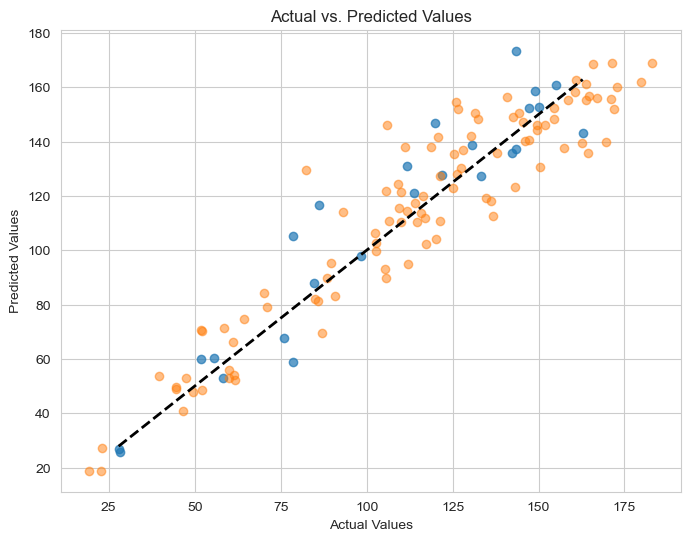

In [23]:
# Visualisierung der tatsächlichen und vorhergesagten Werte in einem Scatter Plot
# y_cv in blau und y_pred_cv in rot
plt.figure(figsize=(8, 6))
plt.scatter(y_cv, y_pred_cv, alpha=0.7)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], 'k--', lw=2)  # Diagonal line
plt.show()


In [24]:
# Tatsächliche und vorhergesagte Werte in einem DataFrame
output_df = pd.DataFrame({'y_cv': y_cv, 'y_pred_cv': y_pred_cv})
print(output_df)

# Excel File mit den tatsächlichen und vorhergesagten Werten
output_df.to_excel('output.xlsx', index=False)

       y_cv   y_pred_cv
52   143.49  137.189682
129   58.27   53.112782
116  142.28  135.690708
178  147.35  152.308818
152   27.87   26.896416
193  133.17  127.236187
155   76.05   67.675595
239  155.09  160.801704
202  113.76  120.979686
18    78.71   58.777933
81    78.49  105.202663
232  143.47  173.448107
131   84.64   87.919272
205   28.19   25.558149
53   111.82  130.898137
179  150.03  152.807263
37    51.95   59.893238
210  162.85  143.025231
38    55.69   60.391683
230  119.76  146.842170
141  130.73  138.703413
180  148.85  158.711111
7    122.01  127.630789
73    98.43   98.040116
85    86.02  116.512725


### Transformierte Daten ausgeben

In [25]:
feature_names_transformed = model.named_steps['columntransformer'].get_feature_names_out()

print("Transformed Feature Names:")
print(feature_names_transformed)

X_transformed = preprocessor.transform(X_train)

# DataFrame mit den transformierten Daten erstellen
transformed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed)

# CSV file erstellen
transformed_df.to_csv('transformed_features.csv', index=False)

Transformed Feature Names:
['num__Alter' 'num__Anzahl Kunden' 'num__Auftragsbestand'
 'cat__Bestandskunden_0.0' 'cat__Bestandskunden_1.0'
 'cat__Skill Level_1.0' 'cat__Skill Level_2.0' 'cat__Skill Level_3.0'
 'cat__Skill Level_4.0' 'cat__Skill Level_5.0' 'cat__Kunden Kategorie_0'
 'cat__Kunden Kategorie_1' 'cat__Kunden Kategorie_2'
 'cat__Kunden Kategorie_3']


# Polynomial features

In den Scatter Plots ist zu erkennen, dass die tatsächlichen und vorhergesagten Werte scheinbar nicht linear miteinander korrelieren.
Es wird getestet, ob eine Polynomial Regression die Performance des Models verbessert.
Wir verwenden PolynomialFeatures für die numerischen Features Alter und Anzahl Kunden.

In [26]:
# Preprocessing der Daten mit einer Polynomial Regression
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2), ['Alter', 'Anzahl Kunden', 'Auftragsbestand']),
        ('num', StandardScaler(), numeric_features_used),
        ('cat', OneHotEncoder(), nominal_features_used + ordinal_features_used),
        # ('ord', OrdinalEncoder(), ordinal_features_used)
    ])
# Pipeline erstellen
poly_model = make_pipeline(poly_preprocessor, LinearRegression())

# Model trainieren
poly_model.fit(X_train, y_train)
y_poly_pred_train = poly_model.predict(X_train)
y_poly_pred_cv = poly_model.predict(X_cv)

# Berechnung des R2 Score
score = poly_model.score(X_cv, y_cv)
print(f"{score*100:.2f}% der Varianz in der Zielvariablen werden durch das Model erklärt.")

poly_rmse_train = np.sqrt(mean_squared_error(y_train, y_poly_pred_train))
poly_rmse = np.sqrt(mean_squared_error(y_cv, y_poly_pred_cv))
poly_ame = np.mean(np.abs(y_cv - y_poly_pred_cv))
poly_ame_train = np.mean(np.abs(y_train - y_poly_pred_train))

print(f'Root Mean Squared Error Train: {poly_rmse_train}')
print(f'Root Mean Squared Error CV: {poly_rmse}')
print(f'Mean Absolute Error Train: {poly_ame_train}')
print(f'Mean Absolute Error CV: {poly_ame}')



86.86% der Varianz in der Zielvariablen werden durch das Model erklärt.
Root Mean Squared Error Train: 13.572184861242036
Root Mean Squared Error CV: 14.563915025005231
Mean Absolute Error Train: 10.21997735601637
Mean Absolute Error CV: 10.578440029323678


Die Ergebnisse der Polynomial Regression sind im Testdatensatz etwas schlechter, als die der linearen Regression. 
Es kann nicht abschließend beurteilt werden, ob die Polynomial Regression die Performance des Models verbessert.
Hierzu wären weitere Daten notwendig.

# Anwendung von Regularisierung auf das Model

In [27]:
from sklearn.linear_model import Ridge

# Ridge regularization
ridge_model = make_pipeline(preprocessor, Ridge(alpha=1))

ridge_model.fit(X_train, y_train)

# Evaluierung des Models mit den Cross Validation Daten
y_pred_cv_ridge = ridge_model.predict(X_cv)
# Evaluierung des Models mit den Trainingsdaten
y_pred_train_ridge = ridge_model.predict(X_train)

# Berechnung des R2 Score
score = ridge_model.score(X_cv, y_cv)
print(f"{score*100:.2f}% der Varianz in der Zielvariablen werden durch das Model erklärt.")

# Mean Squared Error cross validation Daten
mse_cv_ridge = mean_squared_error(y_cv, y_pred_cv_ridge)
# Mean Squared Error Trainingsdaten
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
# Mean Absolute Error mit den CV Daten
mae_cv_ridge = np.mean(np.abs(y_cv - y_pred_cv_ridge))
# Mean Absolute Error mit den Trainingsdaten
mae_train_ridge = np.mean(np.abs(y_train - y_pred_train_ridge))
# Root Mean Squared Error CV Daten
rmse_cv_ridge = np.sqrt(mse_cv_ridge)
# Root Mean Squared Error Trainingsdaten
rmse_train_ridge = np.sqrt(mse_train_ridge)

# ausgeben der Ergebnisse des Ridge Models
print("Results from the ridge model:")
print(f'Root Mean Squared Error CV Ridge: {rmse_cv_ridge}')
print(f'Root Mean Squared Error Train Ridge: {rmse_train_ridge}')
print(f'Mean Absolute Error CV Ridge: {mae_cv_ridge}')
print(f'Mean Absolute Error Train Ridge: {mae_train_ridge}')



87.66% der Varianz in der Zielvariablen werden durch das Model erklärt.
Results from the ridge model:
Root Mean Squared Error CV Ridge: 14.10882521824183
Root Mean Squared Error Train Ridge: 13.914790829295006
Mean Absolute Error CV Ridge: 10.73428327611959
Mean Absolute Error Train Ridge: 10.720536728453569


In [28]:
mlflow.set_experiment("Ridge Regression")

# Starte einen MLflow run
with mlflow.start_run():

    # Logging der Metriken
    mlflow.log_metric("Mean Squared Error CV Ridge", mse_cv_ridge)
    mlflow.log_metric("Mean Absolute Error CV Ridge", mae_cv_ridge)
    mlflow.log_metric("Root Mean Squared Error CV Ridge", rmse_cv_ridge)
    mlflow.log_metric("Mean Squared Error Train Ridge", mse_train_ridge)
    mlflow.log_metric("Mean Absolute Error Train Ridge", mae_train_ridge)
    mlflow.log_metric("Root Mean Squared Error Train Ridge", rmse_train_ridge)
    signature = infer_signature(X_train, model.predict(X_train))

    # Logging des Models
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="turnover_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="lr_model",
    )

/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in 

# Neuronales Netz
Nachdem das Model mit Hilfe von Linearer Regression erstellt wurde, wird nun ein Model mit Hilfe eines neuronalen Netzes erstellt.

In [29]:
import tensorflow as tf
import keras
from keras import layers

mlflow.set_experiment("Neural Network")
mlflow.tensorflow.autolog(registered_model_name="nn_model")

# Trainingsdaten transformieren
X_train_nn = preprocessor.fit_transform(X_train)
# Testdaten transformieren
X_cv_nn = preprocessor.fit_transform(X_cv)

# Neural Network Model erstellen
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    tf.keras.layers.Dropout(0.1),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Komplieren des Models
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error', 'mean_squared_error'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trainieren des Models
nn_model.fit(X_train_nn, y_train, epochs=100, batch_size=32, validation_data=(X_cv_nn, y_cv), callbacks=[early_stopping])


2024/04/20 13:01:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '945b1b91a5274f71af909a74af306d9d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/20 13:01:04 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/100
4/4 [==============================] - 0s 32ms/step - loss: 14714.5703 - mean_absolute_error: 114.2706 - mean_squared_error: 14714.5703 - val_loss: 12810.8135 - val_mean_absolute_error: 105.8503 - val_mean_squared_error: 12810.8135
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 14659.4346 - mean_absolute_error: 113.3217 - mean_squared_error: 14659.4346WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0005s vs `on_train_batch_end` time: 0.0057s). Check your callbacks.


4/4 [==============================] - 0s 5ms/step - loss: 14666.1777 - mean_absolute_error: 114.0553 - mean_squared_error: 14666.1777 - val_loss: 12768.0186 - val_mean_absolute_error: 105.6461 - val_mean_squared_error: 12768.0186
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 14617.0459 - mean_absolute_error: 113.8394 - mean_squared_error: 14617.0459 - val_loss: 12725.4648 - val_mean_absolute_error: 105.4423 - val_mean_squared_error: 12725.4648
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 14573.2979 - mean_absolute_error: 113.6355 - mean_squared_error: 14573.2979 - val_loss: 12682.1602 - val_mean_absolute_error: 105.2319 - val_mean_squared_error: 12682.1602
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 14523.4727 - mean_absolute_error: 113.4105 - mean_squared_error: 14523.4727 - val_loss: 12637.0977 - val_mean_absolute_error: 105.0126 - val_mean_squared_error: 12637.0977
Epoch 6/100
4/4 [=======================

INFO:tensorflow:Assets written to: /var/folders/83/stm6j7fj5cv64zscjwszk3j40000gn/T/tmp_49bdnvk/model/data/model/assets
2024/04/20 13:01:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/04/20 13:01:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Registered model 'nn_mo

In [30]:
from sklearn.metrics import r2_score
# Evaluierung des Models mit den Cross Validation Daten
print("Results for the cross validation data:")
nn_model_cv_results = nn_model.evaluate(X_cv_nn, y_cv)
print(nn_model_cv_results)

# Evaluierung des Models mit den Trainingsdaten
print("Results for the training data:")
nn_model_train_results = nn_model.evaluate(X_train_nn, y_train)
print(nn_model_train_results)
# Ausgabe von RMSE und MAE
print(f'Root Mean Squared Error CV: {np.sqrt(nn_model_cv_results[2])}')
print(f'Root Mean Squared Error Train: {np.sqrt(nn_model_train_results[2])}')
print(f'Mean Absolute Error CV: {nn_model_cv_results[1]}')
print(f'Mean Absolute Error Train: {nn_model_train_results[1]}')


nn_predictions = nn_model.predict(X_cv_nn)

nn_r2 = r2_score(y_cv, nn_predictions)
print(f'R2 Score: {nn_r2}')




Results for the cross validation data:
1/1 [==============================] - 0s 9ms/step - loss: 188.5494 - mean_absolute_error: 10.8246 - mean_squared_error: 188.5494
[188.5494384765625, 10.824610710144043, 188.5494384765625]
Results for the training data:
4/4 [==============================] - 0s 847us/step - loss: 307.1881 - mean_absolute_error: 14.0730 - mean_squared_error: 307.1881
[307.1881103515625, 14.072968482971191, 307.1881103515625]
Root Mean Squared Error CV: 13.731330542833877
Root Mean Squared Error Train: 17.526782658307898
Mean Absolute Error CV: 10.824610710144043
Mean Absolute Error Train: 14.072968482971191
1/1 [==============================] - 0s 6ms/step
R2 Score: 0.883156210599902


In [33]:
# speichern des Models auf der Festplatte
nn_model.save('tf_bt_model.keras')